In [1]:
import numpy as np
import geatpy as ea
import pandas as pd
import networkx as nx
import copy

In [2]:
ea.__version__

'2.6.0'

In [3]:
data = pd.read_excel('data.xlsx')

In [4]:
data.head()

,端点1,端点2,风险值,阻抗值
0,1,2,9,36
1,1,3,6,27
2,2,3,7,13
3,2,4,7,18
4,2,5,9,20


In [5]:
g = nx.Graph()
g.add_edges_from([(i,j) for i,j in zip(data['端点1'], data['端点2'])])

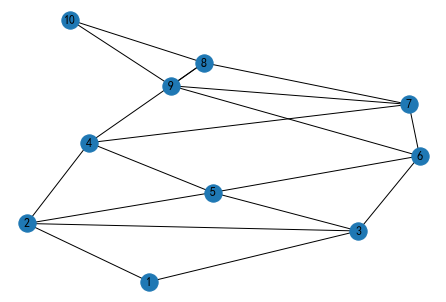

In [6]:
nx.draw(g, with_labels=True)

In [7]:
neighbors = {i:[j for j in g[i]] for i in g.nodes}
neighbors

{1: [2, 3],
 2: [1, 3, 4, 5],
 3: [1, 2, 5, 6],
 4: [2, 7, 8, 5],
 5: [2, 3, 4, 6],
 6: [3, 5, 7, 9],
 7: [4, 6, 8, 9],
 8: [4, 7, 9, 10],
 9: [6, 7, 8, 10],
 10: [8, 9]}

In [8]:
risk_weights = {f'({i}, {j})':k for i,j,k in zip(data['端点1'], data['端点2'], data['风险值'])}
risk_weights.update({f'({j}, {i})':k for i,j,k in zip(data['端点1'], data['端点2'], data['风险值'])})

In [9]:
time_weights = {f'({i}, {j})':k for i,j,k in zip(data['端点1'], data['端点2'], data['阻抗值'])}
time_weights.update({f'({j}, {i})':k for i,j,k in zip(data['端点1'], data['端点2'], data['阻抗值'])})

In [10]:
class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self):
        name = 'Shortest_Path' # 初始化name（函数名称，可以随意设置）
        M = 3 # 初始化M（目标维数）
        maxormins = [1] * M # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 10 # 初始化Dim（决策变量维数）
        varTypes = [1] * Dim # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        lb = [1] * Dim # 决策变量下界
        ub = [10] * Dim # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界
        ubin = [1] * Dim # 决策变量上边界
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 设置每一个结点下一步可达的结点（结点从1开始数，因此列表nodes的第0号元素设为空列表表示无意义）
        self.neighbors = neighbors
        # 设置有向图中各条边的权重
        self.risk_weights = risk_weights
        self.time_weights = time_weights
    
    def decode(self, priority): # 将优先级编码的染色体解码得到一条从节点1到节点10的可行路径
        edges = [] # 存储边
        path = [1] # 结点1是路径起点
        new_neighbors = copy.deepcopy(self.neighbors)
        while not path[-1] == 10: # 开始从起点走到终点
            currentNode = path[-1] # 得到当前所在的结点编号
            nextNodes = new_neighbors[currentNode] # 获取下一步可达的结点组成的列表
            if nextNodes:
                chooseNode = nextNodes[np.argmax(priority[np.array(nextNodes) - 1])] # 从NextNodes中选择优先级更高的结点作为下一步要访问的结点，因为结点从1数起，而下标从0数起，因此要减去1
                path.append(chooseNode)
                edges.append((currentNode, chooseNode))
                for k,v in new_neighbors.items():
                    # 此处移除已经走过的点，注意到未移除遍历过的k，没有必要
                    if chooseNode in v:
                        v.remove(chooseNode)
                        new_neighbors[k] = v
            else:
                break
        return path, edges

    def aimFunc(self, pop): # 目标函数
        f1_objv, f2_objv, f3_objv = np.zeros((pop.sizes, 1)), np.zeros((pop.sizes, 1)), np.zeros((pop.sizes, 1)) # 初始化ObjV
        cv = np.zeros((pop.sizes, 1))
        for i in range(pop.sizes): # 遍历种群的每个个体，分别计算各个个体的目标函数值
            priority = pop.Phen[i, :]
            path, edges = self.decode(priority) # 将优先级编码的染色体解码得到访问路径及经过的边
            risk_value, time_value, link_risk = 0, 0, [10, 0]
            for edge in edges:
                key = str(edge) # 根据路径得到键值，以便根据键值找到路径对应的长度
#                 if not key in self.weights:
#                     raise RuntimeError("Error in aimFunc: The path is invalid. (当前路径是无效的。)", path)
                now_risk = self.risk_weights[key]
                risk_value += now_risk # 将该段风险值加入
                time_value += self.time_weights[key] # 将该段阻抗值加入
                if now_risk < link_risk[0]:
                    link_risk[0] = now_risk
                if now_risk > link_risk[1]:
                    link_risk[1] = now_risk
            f1_objv[i] = risk_value # 计算目标函数值
            f2_objv[i] = time_value
            f3_objv[i] = link_risk[1] - link_risk[0]
            if path[-1] != 10:
                cv[i] = 10000
        pop.CV = cv
        pop.ObjV = np.hstack([f1_objv, f2_objv, f3_objv])  # 把求得的目标函数值赋值给种群pop的ObjV

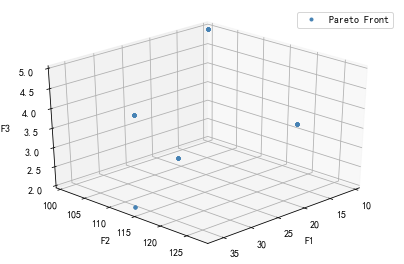

种群信息导出完毕。
用时：1.9185597896575928 秒
非支配个体数：45 个


In [11]:

if __name__ == '__main__':
    """===============================实例化问题对象============================"""
    problem = MyProblem()  # 生成问题对象
    """==================================种群设置==============================="""
    Encoding = 'P'  # 编码方式
    NIND = 50  # 种群规模
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders)  # 创建区域描述器
    population = ea.Population(Encoding, Field, NIND)  # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
    """================================算法参数设置============================="""
    myAlgorithm = ea.moea_NSGA3_templet(problem, population)  # 实例化一个算法模板对象
    myAlgorithm.mutOper.Pm = 0.2  # 修改变异算子的变异概率
    myAlgorithm.recOper.XOVR = 0.9  # 修改交叉算子的交叉概率
    myAlgorithm.MAXGEN = 200  # 最大进化代数
    myAlgorithm.logTras = 0  # 设置每多少代记录日志，若设置成0则表示不记录日志
    myAlgorithm.verbose = False  # 设置是否打印输出日志信息
    myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）
    """==========================调用算法模板进行种群进化=========================
    调用run执行算法模板，得到帕累托最优解集NDSet以及最后一代种群。NDSet是一个种群类Population的对象。
    NDSet.ObjV为最优解个体的目标函数值；NDSet.Phen为对应的决策变量值。
    详见Population.py中关于种群类的定义。
    """
    [NDSet, population] = myAlgorithm.run()  # 执行算法模板，得到非支配种群以及最后一代种群
    NDSet.save()  # 把非支配种群的信息保存到文件中
    """==================================输出结果=============================="""
    print('用时：%s 秒' % myAlgorithm.passTime)
    print('非支配个体数：%d 个' % NDSet.sizes) if NDSet.sizes != 0 else print('没有找到可行解！')

In [53]:
id_ = 3
best_journey, edges = problem.decode(NDSet.Phen[id_])
print(best_journey)
NDSet.ObjV[id_]

[1, 3, 2, 4, 8, 10]


array([ 29., 114.,   3.])

In [12]:
best_ls = []
for i in range(45):
    best_journey, edges = problem.decode(NDSet.Phen[i])
    if best_journey not in best_ls:
        best_ls.append(best_journey)

In [13]:
best_ls

[[1, 3, 2, 4, 8, 10],
 [1, 3, 6, 9, 10],
 [1, 3, 6, 9, 8, 10],
 [1, 2, 4, 7, 8, 10],
 [1, 3, 2, 4, 7, 8, 10]]